In [1]:
%run ../../_setup.py

import numpy as np
import xarray as xr
from netCDF4 import Dataset
from pandas import to_datetime
from scipy.interpolate import griddata

import pyproj

from gsw import IPV_vs_fNsquared_ratio, f, Nsquared
from OceanPy.kinematics import gradient_wind_from_ssh

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cmo

# https://docs.scipy.org/doc/scipy-0.7.x/reference/generated/scipy.stsci.convolve.boxcar.html
# https://pypi.org/project/stsci.convolve/#description
from stsci.convolve import boxcar

In [2]:
savefig = False

## Relative and absolute vorticity from SSH

In [3]:
# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_135_-53_149_-47_199803_gw.nc')
ssh = xr.open_dataset(input_file)
gw = xr.open_dataset(input_file, group='GW')

# transform polar in cartesian coordinate system
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# select data range
west = 135 #137
south = -53.4 #-52.4
east = 149 #147
north = -47 #-48

# select time
timevoy = slice('1998-03-12', '1998-03-28')
# timevoy = slice('1998-08-15', '1998-10-15')

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north))


# load bathymetry (1 arc-minute resolution)
# input_file = os.path.join(datadir, 'external', 'bathymetry', 'smith_and_sandwell_1997', 
#                           'bathymetry_-48_137_-58_157.nc')
input_file = os.path.join(datadir, 'external', 'bathymetry', 'gebco_2019', 'bodc_res30sec', 
                          'GEBCO_2014_2D_137.0_-58.0_147.0_-48.0.nc')
bathy = xr.open_dataset(input_file)

try:
    dep = bathy.sel(longitude=slice(west, east), latitude=slice(north, south))
    lonH, latH = dep.longitude, dep.latitude
except:
    # boundaries
    west = 137
    south = -48
    east = 147
    north = -52.4
#     south = -47
#     north = -53.4

    dep = bathy.elevation.sel(lon=slice(west, east), lat=slice(north, south))
    lonH, latH = dep.lon, dep.lat

lnlnH, ltltH = np.meshgrid(lonH, latH)

# load ctd data
input_file = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = xr.open_dataset(input_file)

transects = {1: list(range(3, 11)), 2: list(reversed(range(11, 19))), 3: list(range(19, 28)),
         4: list(reversed(range(27, 35))), 5: list(range(37, 47)), 6: list(reversed(range(47, 58))),
         7: list(range(57, 66)), 8: list(range(69, 77)), 9: list(reversed(range(77, 85))),
         10: list(range(85, 92)), 11: list(reversed([94, 93] + list(range(95, 102))))}

In [4]:
# notice: 'ugeos' and 'vgeos' are calculated within function, not taken from AVISO product
# TODO: check in gradient_wind_from_ssh the calculation of orientation, and compare with function gradient_balance_from_ssh
# gw = gradient_wind_from_ssh(ssh, variables=('adt', 'ugos', 'vgos'), transform=UTM54)
loni, lati = gw.longitude.data, gw.latitude.data

lnln, ltlt = np.meshgrid(loni, lati)
xx, yy = pyproj.transform(WGS84, UTM54, lnln, ltlt)

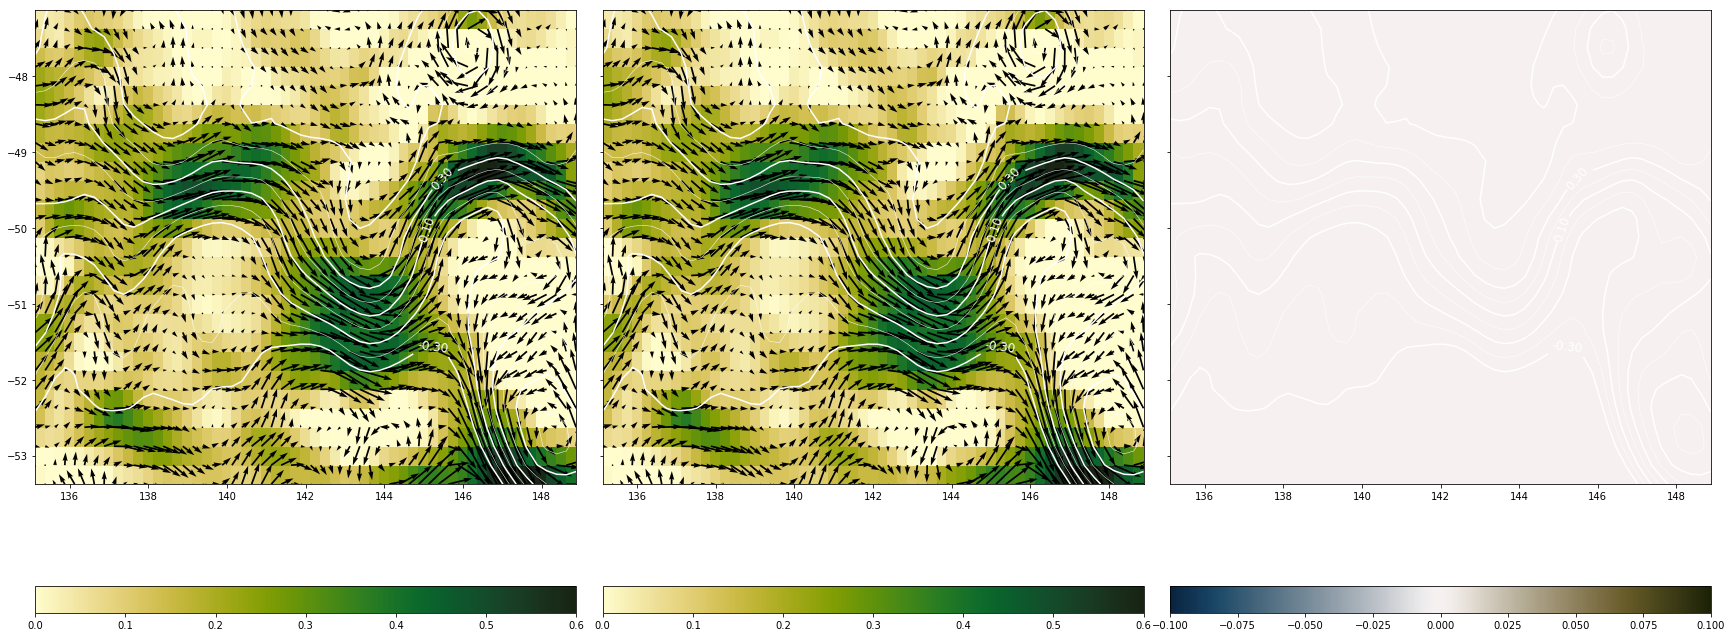

In [5]:
fs_small=12

fig, ax = plt.subplots(1, 3, figsize=(24, 10), sharey=True)
fig.tight_layout()

# plot voyagemean ADT contours
bounds = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
manual = [(145.25, -51.5), (145, -50),  (145.5, -49.35)]
for iax in range(len(ax)):
    ct = ax[iax].contour(ssh.longitude, ssh.latitude, ssh.adt.sel(time=timevoy).mean('time'), bounds, 
                         colors='w', linestyles='solid', linewidths=0.5)
    for ib, b in enumerate(bounds):
        if b in bounds[0::2]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=1.5)
    ax[iax].clabel(ct, bounds[0::2], inline=1, fontsize=fs_small, fmt='%.2f', manual=manual)


pcol = ax[0].pcolor(ssh.longitude, ssh.latitude, ssh.ugos.sel(time=timevoy).mean('time'), 
                 vmin=0, vmax=0.6, cmap=cmo.cm.speed)
quiv = ax[0].quiver(ssh.longitude, ssh.latitude, 
                    ssh.ugos.sel(time=timevoy).mean('time'), ssh.vgos.sel(time=timevoy).mean('time'),
                    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')
fig.colorbar(pcol, ax=ax[0], orientation='horizontal')


pcol = ax[1].pcolor(ssh.longitude, ssh.latitude, gw.ugeos.sel(time=timevoy).mean('time'), 
                 vmin=0, vmax=0.6, cmap=cmo.cm.speed)
quiv = ax[1].quiver(ssh.longitude, ssh.latitude, 
                    gw.ugrad.sel(time=timevoy).mean('time'), gw.vgrad.sel(time=timevoy).mean('time'),
                    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')
fig.colorbar(pcol, ax=ax[1], orientation='horizontal')

pcol = ax[2].pcolor(ssh.longitude, ssh.latitude, (ssh.ugos.sel(time=timevoy) - gw.ugeos.sel(time=timevoy)).mean('time'), 
                 vmin=-0.1, vmax=0.1, cmap=cmo.cm.diff)
fig.colorbar(pcol, ax=ax[2], orientation='horizontal')

In [6]:
# # plt.pcolor(gw.longitude, gw.latitude, np.gradient(gw.ugrad)[2][90,])
# t = 60
# plt.figure()
# plt.pcolor(ssh.longitude, ssh.latitude, ssh.adt[t,])

# u = np.gradient(ssh.adt[t])[0] / np.gradient(yy)[0]

# plt.figure()
# plt.pcolor(ssh.longitude, ssh.latitude, u)

# # https://docs.scipy.org/doc/scipy-0.7.x/reference/generated/scipy.stsci.convolve.boxcar.html
# # https://pypi.org/project/stsci.convolve/#description
# from stsci.convolve import boxcar

# plt.figure()
# plt.pcolor(ssh.longitude, ssh.latitude, boxcar(u,(3,3)))

In [7]:
# print(ssh.ugos[75,].shape, xx.shape)
# plt.figure()
# plt.pcolor(xx, yy, ssh.vgos[75,])
# plt.contour(xx, yy, ssh.adt[75,], colors='k')

# plt.figure()
# pcol = plt.pcolor(xx, yy, (np.gradient(ssh.ugos[75,])[1] / np.gradient(xx)[1]) + (np.gradient(ssh.vgos[75,])[0] / np.gradient(yy)[0]))
# plt.contour(xx, yy, ssh.adt[75,], colors='k')
# plt.colorbar(pcol)


In [8]:
# determine planetary vorticity
fcor = xr.DataArray(f(ltlt), dims=['latitude', 'longitude'], coords=[ssh.latitude, ssh.longitude])
beta = np.gradient(fcor)[0] / np.gradient(yy)[0]
fcorH = f(ltltH)

# ageostrophic velocities
ua, va = (gw.ugrad - gw.ugeos), (gw.vgrad - gw.vgeos)
grid_point = (3, 3)

# calculate flow speed, relative vorticity and divergence
zeta = np.ma.masked_all(gw.Vgrad.shape)
# dzetadx, dzetady = zeta.copy(), zeta.copy()
sn, ss = zeta.copy(), zeta.copy()
divgeos, dwdz  = zeta.copy(), zeta.copy()
fdwdz, betavg, ugradzeta = zeta.copy(), zeta.copy(), zeta.copy()
for t in range(len(gw.time)):
#     dvdx = boxcar(np.gradient(gw.vgrad[t,])[1] / np.gradient(xx)[1], grid_point)
#     dudy = boxcar(np.gradient(gw.ugrad[t,])[0] / np.gradient(yy)[0], grid_point)
    
#     dudx = boxcar(np.gradient(gw.ugrad[t,])[1] / np.gradient(xx)[1], grid_point)
#     dvdy = boxcar(np.gradient(gw.vgrad[t,])[0] / np.gradient(yy)[0], grid_point)
    
    dvdx = boxcar(np.gradient(gw.vgeos[t,])[1] / np.gradient(xx)[1], grid_point)
    dudy = boxcar(np.gradient(gw.ugeos[t,])[0] / np.gradient(yy)[0], grid_point)
    
    dudx = boxcar(np.gradient(gw.ugeos[t,])[1] / np.gradient(xx)[1], grid_point)
    dvdy = boxcar(np.gradient(gw.vgeos[t,])[0] / np.gradient(yy)[0], grid_point)

    # (gradients of) relative vorticity
    zeta[t,] = dvdx - dudy
    dzetadx = boxcar(np.gradient(zeta[t,])[1] / np.gradient(xx)[1], grid_point)
    dzetady = boxcar(np.gradient(zeta[t,])[0] / np.gradient(yy)[0], grid_point)
    
    # normal and shear components of strain
    sn[t,] = dudx - dvdy
    ss[t,] = dvdx + dudy

    # divergence of velocity field
    dugdx = boxcar(np.gradient(gw.ugeos[t,])[1] / np.gradient(xx)[1], grid_point)
    dvgdy = boxcar(np.gradient(gw.vgeos[t,])[0] / np.gradient(yy)[0], grid_point)
    
    divgeos[t,] = -(dugdx + dvgdy)
    
    duadx = boxcar(np.gradient(ua[t,])[1] / np.gradient(xx)[1], grid_point)
    dvady = boxcar(np.gradient(va[t,])[0] / np.gradient(yy)[0], grid_point)
    
    # calculate vortivity budget terms
    fdwdz[t,] = - fcor * (duadx + dvady) - (beta * gw.vgeos[t,])
    betavg[t,] = beta * gw.vgeos[t,] # TODO: total velocity of geostrophic velocity???
#     ugradzeta[t,] = (gw.ugrad[t,] * dzetadx) + (gw.vgrad[t,] * dzetady)
    ugradzeta[t,] = (gw.ugeos[t,] * dzetadx) + (gw.vgeos[t,] * dzetady)

#     del dvdx, dudy, dudx, dvdy, dugdx, dvgdy, duadx, dvady, dzetadx, dzetady
    


# Save in dataarray,
# TODO: save in DataSet
zeta = xr.DataArray(zeta, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
# dzetadx = xr.DataArray(dzetadx, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
# dzetady = xr.DataArray(dzetady, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

# dwdz = xr.DataArray(dwdz, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
# divgeos = xr.DataArray(divgeos, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

# calculate vortivity budget terms
# ugradzeta = (gw.ugrad * (np.gradient(zeta)[1] / np.gradient(xx)[1])) + (gw.vgrad * (np.gradient(zeta)[0] / np.gradient(yy)[0]))
# fdwdz = - fcor.data * ((np.gradient(ua)[1] / np.gradient(xx)[1]) + (np.gradient(va)[0] / np.gradient(yy)[0]))
# betavg = beta * gw.vgeos

# ugradzeta = gw.ugrad.sel(time=timevoy).mean('time').data * dzetadx.sel(time=timevoy).mean('time').data + \
# gw.vgrad.sel(time=timevoy).mean('time').data * dzetady.sel(time=timevoy).mean('time').data

# ugradzeta = gw.ugrad.sel(time=timevoy).mean('time').data * (np.gradient(zeta.sel(time=timevoy).mean('time').data)[1] / np.gradient(xx)[1]) + \
# gw.vgrad.sel(time=timevoy).mean('time').data * (np.gradient(zeta.sel(time=timevoy).mean('time').data)[0] / np.gradient(yy)[0])

# betavg = (np.gradient(fcor)[0] / np.gradient(yy)[0]) * gw.vgeos.sel(time=timevoy).mean('time')
# fdwdz = fcor * dwdz.sel(time=timevoy).mean('time')

# calculate vortivity budget terms
ugradzeta = xr.DataArray(ugradzeta, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
betavg = xr.DataArray(betavg, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
fdwdz = xr.DataArray(fdwdz, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
                                                                                                       
# calculate Okubu-Weiss parameter
# sn = xr.DataArray(sn, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
# ss = xr.DataArray(ss, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
OW = sn**2 + ss**2 - zeta**2
OW = xr.DataArray(OW, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

# OW = sn.sel(time=timevoy).mean('time').data**2 + ss.sel(time=timevoy).mean('time').data**2 - zeta.sel(time=timevoy).mean('time').data**2
# W = xr.DataArray(W, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])



In [9]:
west = 137
south = -52.4
east = 147
north = -48
zeta_sel = zeta.sel(longitude=slice(west, east), latitude=slice(south, north), time=timevoy).mean('time')
fcor_sel = fcor.sel(longitude=slice(west, east), latitude=slice(south, north))

In [10]:
(zeta_sel / fcor_sel).max()

<xarray.DataArray ()>
array(0.12569297)

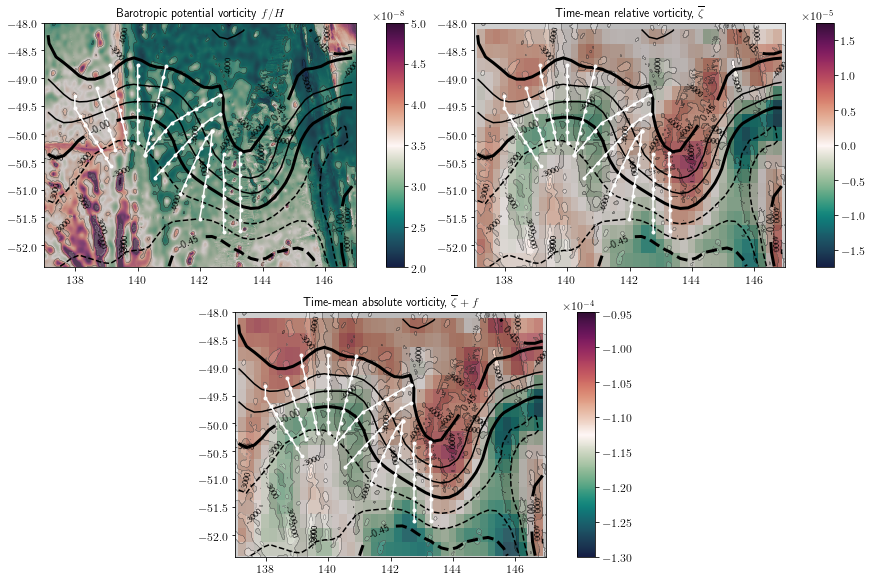

In [11]:
fs_small = 12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('text', usetex=True)

fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(ncols=4, nrows=4)
fig.tight_layout()

ax0 = fig.add_subplot(gs[:2, :2])
ax1 = fig.add_subplot(gs[:2, 2:])
ax2 = fig.add_subplot(gs[2:4, 1:3])
ax = fig.get_axes()

# barotropic potential vorticity
vmin, vmax = 2e-8, 5e-8
pcol = ax[0].pcolor(lonH, latH, fcorH/dep,
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
plt.colorbar(pcol, ax=ax[0])
ax[0].set_title('Barotropic potential vorticity $f/H$')

# mean relative vorticity
vmin, vmax = -1.75e-5, 1.75e-5
pcol = ax[1].pcolor(zeta_sel.longitude, zeta_sel.latitude, zeta_sel, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[1].set_title(r'Time-mean relative vorticity, $\overline{\zeta}$')

# mean absolute vorticity
vmin, vmax = -0.95e-4, -1.3e-4
pcol = ax[2].pcolor(zeta_sel.longitude, zeta_sel.latitude, zeta_sel + fcor_sel, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[2])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[2].set_title(r'Time-mean absolute vorticity, $\overline{\zeta} + f$')

bounds = np.linspace(-0.45, 0.75, 9)
depths = np.linspace(-5000, -1000, 5)
for i in range(len(ax)):

    # plot dynamic height contours
    ct = ax[i].contour(zeta_sel.longitude, zeta_sel.latitude, ssh.adt.sel(longitude=slice(west, east), latitude=slice(south, north), time=timevoy).mean('time'), bounds, colors='k')
    for ib, b in enumerate(bounds):
        if b in bounds[0::3]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=3)
    ax[i].clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

    # plot depth contours
    ax[i].contourf(lnlnH, ltltH, dep, depths, 
                       cmap=plt.cm.binary_r, alpha=0.3)
    dc = ax[i].contour(lnlnH, ltltH, dep, depths, 
                       colors='k', linewidths=0.2, linestyles='solid')
    ax[i].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

#     # plot observations domain
#     ax[i].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
#                facecolor='none', edgecolor='m', linewidth=3)
    
    # plot transects
    for transect in transects.keys():
        istations = np.array(transects[transect]) - 1

        ax[i].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 'w.-')

In [12]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '09_potential_vorticity_terms' + extension),
                   transparent=True)

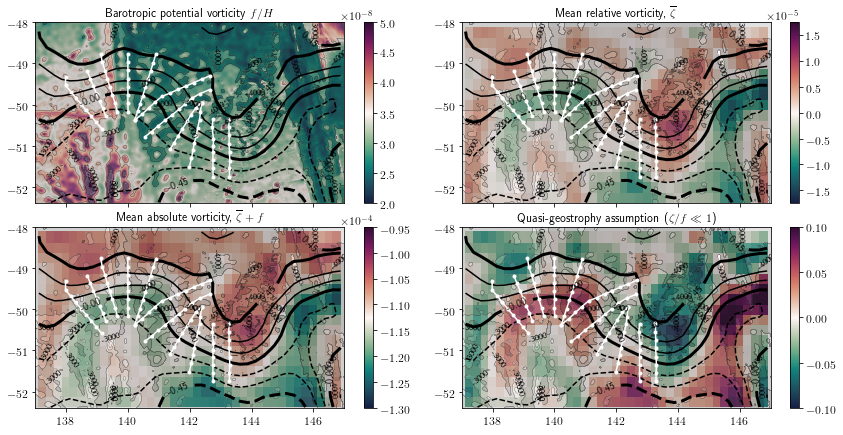

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.tight_layout()

# barotropic potential vorticity
vmin, vmax = 2e-8, 5e-8
pcol = ax[0, 0].pcolor(lonH, latH, fcorH/dep,
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
plt.colorbar(pcol, ax=ax[0, 0])
ax[0, 0].set_title('Barotropic potential vorticity $f/H$')

# mean relative vorticity
vmin, vmax = -1.75e-5, 1.75e-5
pcol = ax[0, 1].pcolor(zeta_sel.longitude, zeta_sel.latitude, zeta_sel, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0, 1])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[0, 1].set_title(r'Mean relative vorticity, $\overline{\zeta}$')

# mean absolute vorticity
vmin, vmax = -0.95e-4, -1.3e-4
pcol = ax[1, 0].pcolor(zeta_sel.longitude, zeta_sel.latitude, zeta_sel + fcor_sel, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 0])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[1, 0].set_title(r'Mean absolute vorticity, $\overline{\zeta} + f$')

# mean relative vorticity advection
vmin, vmax = -1e-1, 1e-1
pcol = ax[1, 1].pcolor(zeta_sel.longitude, zeta_sel.latitude, zeta_sel / fcor_sel, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 1])
ax[1, 1].set_title(r'Quasi-geostrophy assumption ($\zeta/f \ll 1$)')

bounds = np.linspace(-0.45, 0.75, 9)
depths = np.linspace(-5000, -1000, 5)
# for i in range(len(ax)):
row, col = ax.shape
for r in range(row):
    for c in range(col):    
        # plot dynamic height contours
        ct = ax[r, c].contour(zeta_sel.longitude, zeta_sel.latitude, ssh.adt.sel(longitude=slice(west, east), latitude=slice(south, north), time=timevoy).mean('time'), bounds, colors='k')
        for ib, b in enumerate(bounds):
            if b in bounds[0::3]:
                zc = ct.collections[ib]
                plt.setp(zc, linewidth=3)
        ax[r, c].clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

        # plot depth contours
        ax[r, c].contourf(lnlnH, ltltH, dep, depths, 
                           cmap=plt.cm.binary_r, alpha=0.3)
        dc = ax[r, c].contour(lnlnH, ltltH, dep, depths, 
                           colors='k', linewidths=0.2, linestyles='solid')
        ax[r, c].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

#         # plot observations domain
#         ax[r, c].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
#                    facecolor='none', edgecolor='m', linewidth=3)

        # plot transects
        for transect in transects.keys():
            istations = np.array(transects[transect]) - 1
            ax[r, c].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 'w.-')

#     ax[i].set_aspect('equal')

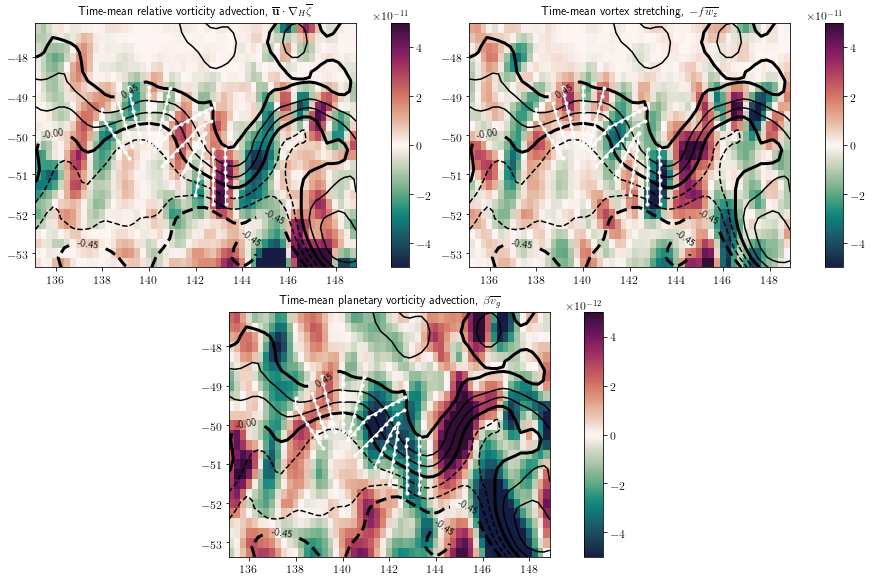

In [14]:
import string
fs_small=12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('text', usetex=True)

fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(ncols=4, nrows=4)
fig.tight_layout()

ax0 = fig.add_subplot(gs[:2, :2])
ax1 = fig.add_subplot(gs[:2, 2:])
ax2 = fig.add_subplot(gs[2:4, 1:3])
ax = fig.get_axes()

# mean relative vorticity advection
vmin, vmax = -5e-11, 5e-11
pcol = ax[0].pcolor(loni, lati, ugradzeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0])
ax[0].set_title(r'Time-mean relative vorticity advection, $\overline{\bf u} \cdot \nabla_H\overline{\zeta}$')

# time-mean vortex stretching
# vmin, vmax = -1e-10, 1e-10
pcol = ax[1].pcolor(loni, lati, -fdwdz.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1])
# cbar.formatter.set_powerlimits((0, 0))
# cbar.update_ticks()
ax[1].set_title(r'Time-mean vortex stretching, $-f\overline{w_z}$')

# mean planetary vorticity advectiom
vmin, vmax = -0.5e-11, 0.5e-11
pcol = ax[2].pcolor(loni, lati, betavg.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[2])
# cbar.formatter.set_powerlimits((0, 0))
# cbar.update_ticks()
ax[2].set_title(r'Time-mean planetary vorticity advection, $\beta\overline{v_g}$')

bounds = np.linspace(-0.45, 0.75, 9)
depths = np.linspace(-5000, -1000, 5)
for i in range(len(ax)):
# row, col = ax.shape
# for r in range(row):
#     for c in range(col):    
    # plot dynamic height contours
    ct = ax[i].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
    for ib, b in enumerate(bounds):
        if b in bounds[0::3]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=3)
    ax[i].clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

#         # plot depth contours
#         ax[r, c].contourf(lnlnH, ltltH, dep, depths, 
#                            cmap=plt.cm.binary_r, alpha=0.3)
#         dc = ax[r, c].contour(lnlnH, ltltH, dep, depths, 
#                            colors='k', linewidths=0.2, linestyles='solid')
#         ax[r, c].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

#     # plot observations domain
#     ax[i].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
#                facecolor='none', edgecolor='m', linewidth=3)
    
    # plot transects
    for transect in transects.keys():
        istations = np.array(transects[transect]) - 1
        ax[i].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 'w.-')

In [15]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '10_vorticity_balance_terms' + extension),
                   transparent=True)

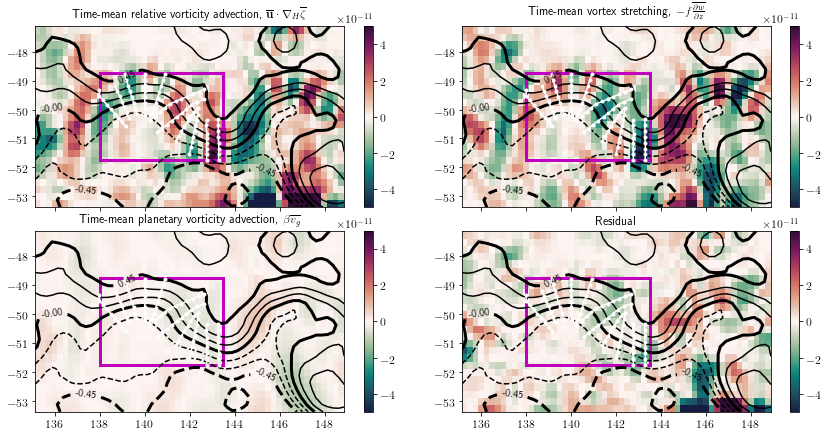

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.tight_layout()

# mean relative vorticity advection
vmin, vmax = -5e-11, 5e-11
pcol = ax[0, 0].pcolor(loni, lati, ugradzeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0, 0])
ax[0, 0].set_title(r'Time-mean relative vorticity advection, $\overline{\bf u} \cdot \nabla_H\overline{\zeta}$')

# time-mean vortex stretching
# vmin, vmax = -1e-10, 1e-10
pcol = ax[0, 1].pcolor(loni, lati, -fdwdz.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0, 1])
# cbar.formatter.set_powerlimits((0, 0))
# cbar.update_ticks()
ax[0, 1].set_title(r'Time-mean vortex stretching, $-f\overline{\frac{\partial w}{\partial z}}$')

# mean planetary vorticity advectiom
# vmin, vmax = -0.5e-11, 0.5e-11
pcol = ax[1, 0].pcolor(loni, lati, betavg.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 0])
# cbar.formatter.set_powerlimits((0, 0))
# cbar.update_ticks()
ax[1, 0].set_title(r'Time-mean planetary vorticity advection, $\beta\overline{v_g}$')

# divergence of horizontal velocity
# vmin, vmax = -1e-5, 1e-5
pcol = ax[1, 1].pcolor(loni, lati, 
                       + ugradzeta.sel(time=timevoy).mean('time') 
                       - fdwdz.sel(time=timevoy).mean('time') 
                       + betavg.sel(time=timevoy).mean('time'),
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 1])
ax[1, 1].set_title(r'Residual')


bounds = np.linspace(-0.45, 0.75, 9)
depths = np.linspace(-5000, -1000, 5)
# for i in range(len(ax)):
row, col = ax.shape
for r in range(row):
    for c in range(col):    
        # plot dynamic height contours
        ct = ax[r, c].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
        for ib, b in enumerate(bounds):
            if b in bounds[0::3]:
                zc = ct.collections[ib]
                plt.setp(zc, linewidth=3)
        ax[r, c].clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

#         # plot depth contours
#         ax[r, c].contourf(lnlnH, ltltH, dep, depths, 
#                            cmap=plt.cm.binary_r, alpha=0.3)
#         dc = ax[r, c].contour(lnlnH, ltltH, dep, depths, 
#                            colors='k', linewidths=0.2, linestyles='solid')
#         ax[r, c].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

        # plot observations domain
        ax[r, c].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
                   facecolor='none', edgecolor='m', linewidth=3)
        
        # plot transects
        for transect in transects.keys():
            istations = np.array(transects[transect]) - 1
            ax[r, c].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 'w.-')
    
#     ax[i].set_aspect('equal')

## Strain-shear Okubu-Weiss parameter from SSH

In [17]:
# vmin, vmax = Wcenter + W0 - 1e-10, Wcenter + W0 + 1e-14
# print(vmin, vmax)


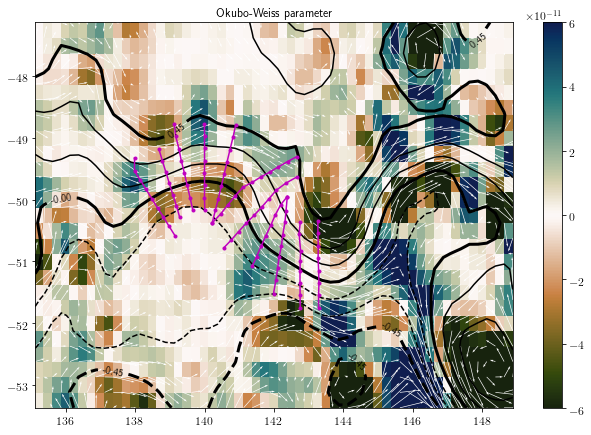

In [23]:
fig, ax = plt.subplots(figsize=(9, 6), sharex=True)
fig.tight_layout()

# plot relative vorticity field
# vmin, vmax = Wcenter + W0 - 1e-12, Wcenter + W0 + 1e-12
vmin, vmax = -6e-11, 6e-11
axis=0
pcol = ax.pcolor(loni, lati, OW.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.tarn)
plt.colorbar(pcol)
ax.set_title('Okubo-Weiss parameter')

# for i in range(len(ax)):
    
# plot dynamic height contours
ct = ax.contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
for ib, b in enumerate(bounds):
    if b in bounds[0::3]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=3)
ax.clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

quiv = ax.quiver(loni, lati, ssh.ugos.sel(time=timevoy).mean('time'), ssh.vgos.sel(time=timevoy).mean('time'), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='w')

#     # plot depth contours
#     ax[i].contourf(lonlonH, latlatH, dep, depths, 
#                        cmap=plt.cm.binary_r, alpha=0.3)
#     dc = ax[i].contour(lonlonH, latlatH, dep, depths, 
#                        colors='k', linewidths=0.2, linestyles='solid')
#     ax[i].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

# # plot observations domain
# ax.fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
#            facecolor='none', edgecolor='m', linewidth=3)

# plot transects
for transect in transects.keys():
    istations = np.array(transects[transect]) - 1
    ax.plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 'm.-')



In [28]:
np.nanmean(dvdx)

4.607890841508556e-08

In [19]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '11_okubo-weiss_parameter' + extension),
                   transparent=True)

In [20]:
loni, lati = ssh.longitude.data, ssh.latitude.data
lonlon, latlat = np.meshgrid(loni, lati)
xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

# calculate flow speed, relative vorticity and divergence
zeta = np.ma.masked_all(ssh.ugos.shape)
dzetadx, dzetady = zeta.copy(), zeta.copy()
Sn, Ss = zeta.copy(), zeta.copy()
for t in range(len(ssh.time)):
    dvdx = np.gradient(ssh.vgos[t,])[1] / np.gradient(xx)[1]
    dudy = np.gradient(ssh.ugos[t,])[0] / np.gradient(yy)[0]
    
    dudx = np.gradient(ssh.ugos[t,])[0] / np.gradient(xx)[1]
    dvdy = np.gradient(ssh.vgos[t,])[1] / np.gradient(yy)[0]

    zeta[t,] = dvdx - dudy
    dzetadx[t,] = np.gradient(zeta[t,])[1] / np.gradient(xx)[1]
    dzetady[t,] = np.gradient(zeta[t,])[0] / np.gradient(yy)[0]

    Sn[t,] = dudx - dvdy
    Ss[t,] = dvdx + dudy
#     div[t,] = dudx + dvdy

zeta = xr.DataArray(zeta, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
dzetadx = xr.DataArray(dzetadx, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
dzetady = xr.DataArray(dzetady, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

udivzeta = ssh.ugos.sel(time=timevoy).mean('time').data * dzetadx.sel(time=timevoy).mean('time').data + \
ssh.vgos.sel(time=timevoy).mean('time').data * dzetady.sel(time=timevoy).mean('time').data



# Sn = xr.DataArray(Sn, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
# Ss = xr.DataArray(Ss, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])


# determine planetary vorticity
fcor = f(latlat)

# grid bathymetry on ssh grid
# points = list(zip(lonlonH[:].flatten(), latlatH[:].flatten()))
# values = dep.data.flatten()
# H = griddata(points, values, (lonlon, latlat), method='linear')
fcorH = f(latlatH)

# average dynamic height contours over time of the voyage
# D = np.mean(ssh.adt[timevoy], axis=0)

NameError: name 'latlatH' is not defined

In [ ]:

# xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

loni, lati = ssh.longitude.data, ssh.latitude.data
lonlon, latlat = np.meshgrid(loni, lati)
xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

# calculate flow speed, relative vorticity and divergence
zeta = np.ma.masked_all(ssh.ugos.shape)
dzetadx, dzetady = zeta.copy(), zeta.copy()
Sn, Ss = zeta.copy(), zeta.copy()
for t in range(len(ssh.time)):
    dvdx = np.gradient(ssh.vgos[t,])[1] / np.gradient(xx)[1]
    dudy = np.gradient(ssh.ugos[t,])[0] / np.gradient(yy)[0]
    
    dudx = np.gradient(ssh.ugos[t,])[0] / np.gradient(xx)[1]
    dvdy = np.gradient(ssh.vgos[t,])[1] / np.gradient(yy)[0]

    zeta[t,] = dvdx - dudy
    dzetadx[t,] = np.gradient(zeta[t,])[1] / np.gradient(xx)[1]
    dzetady[t,] = np.gradient(zeta[t,])[0] / np.gradient(yy)[0]

    Sn[t,] = dudx - dvdy
    Ss[t,] = dvdx + dudy
#     div[t,] = dudx + dvdy

zeta = xr.DataArray(zeta, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
dzetadx = xr.DataArray(dzetadx, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
dzetady = xr.DataArray(dzetady, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

udivzeta = ssh.ugos.sel(time=timevoy).mean('time').data * dzetadx.sel(time=timevoy).mean('time').data + \
ssh.vgos.sel(time=timevoy).mean('time').data * dzetady.sel(time=timevoy).mean('time').data


# Okubu-Weiss parameter
Sn = xr.DataArray(Sn, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
Ss = xr.DataArray(Ss, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
OW = Sn**2 + Ss**2 - zeta**2

# determine planetary vorticity
fcor = f(latlat)

# grid bathymetry on ssh grid
# points = list(zip(lonlonH[:].flatten(), latlatH[:].flatten()))
# values = dep.data.flatten()
# H = griddata(points, values, (lonlon, latlat), method='linear')
fcorH = f(latlatH)

# average dynamic height contours over time of the voyage
# D = np.mean(ssh.adt[timevoy], axis=0)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.tight_layout()

# barotropic potential vorticity
vmin, vmax = 2e-8, 5e-8
pcol = ax[0, 0].pcolor(lonH, latH, fcorH/dep,
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
plt.colorbar(pcol, ax=ax[0, 0])
ax[0, 0].set_title('Barotropic potential vorticity $f/H$')

# mean relative vorticity
vmin, vmax = -1.75e-5, 1.75e-5
pcol = ax[0, 1].pcolor(loni, lati, zeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0, 1])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[0, 1].set_title(r'Mean relative vorticity, $\langle\zeta\rangle$')

# mean absolute vorticity
vmin, vmax = -0.95e-4, -1.3e-4
pcol = ax[1, 0].pcolor(loni, lati, zeta.sel(time=timevoy).mean('time') + fcor, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 0])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[1, 0].set_title(r'Mean absolute vorticity, $\langle\zeta\rangle + f$')

# mean relative vorticity advection
vmin, vmax = -1e-10, 1e-10
pcol = ax[1, 1].pcolor(loni, lati, udivzeta, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 1])
ax[1, 1].set_title(r'Mean relative vorticity advection, $\langle\vec{u}\rangle\cdot\nabla_H\langle\zeta\rangle$')

bounds = np.linspace(-0.45, 0.75, 9)
depths = np.linspace(-5000, -1000, 5)
# for i in range(len(ax)):
row, col = ax.shape
for r in range(row):
    for c in range(col):    
        # plot dynamic height contours
        ct = ax[r, c].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
        for ib, b in enumerate(bounds):
            if b in bounds[0::3]:
                zc = ct.collections[ib]
                plt.setp(zc, linewidth=3)
        ax[r, c].clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

        # plot depth contours
        ax[r, c].contourf(lonlonH, latlatH, dep, depths, 
                           cmap=plt.cm.binary_r, alpha=0.3)
        dc = ax[r, c].contour(lonlonH, latlatH, dep, depths, 
                           colors='k', linewidths=0.2, linestyles='solid')
        ax[r, c].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

        # plot observations domain
        ax[r, c].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
                   facecolor='none', edgecolor='m', linewidth=3)
    
#     ax[i].set_aspect('equal')

## Potential vorticity from CTD profiles per transect

In [ ]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

In [ ]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# transect stations
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}


# calculate Isopycnal Potential Vorticity
IPV_fN2, p_mid = IPV_vs_fNsquared_ratio(ctd['SA'][:], ctd['CT'][:], ctd['p'][:], p_ref=p_ref, axis=1)
N2 = Nsquared(ctd['SA'][:], ctd['CT'][:], ctd['p'][:], ctd['lat'][:, 0], axis=1,)[0]
fcor = np.broadcast_to(f(ctd['lat'][:, 0])[np.newaxis,:].T, IPV_fN2.shape)

IPV = IPV_fN2 * fcor * N2


In [ ]:
pressure_levels = {}
for ip, p in enumerate(p_mid[0].data):
    pressure_levels[p] = ip


## Buoyancy frequency

In [ ]:
cmap = cmo.cm.curl
# bounds = np.linspace(-5e-9, 5e-9, 21)
# norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True)

for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], ctd['p'][:], np.log10(N2[stations]).T, cmap=plt.cm.jet, vmin=-7, vmax=-3)

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])

In [ ]:
# p_int = 401 #dbar
# lon = ctd['lon'][:, 0]
# ip = pressure_levels[p_int]

## Horizontal PV at depth layer

https://www.ldeo.columbia.edu/~pierred/Research/mindanao/Potential_Vorticity_fields.html

In [ ]:
IPV.min(), IPV.max()

In [ ]:
cmap = plt.cm.jet
# bounds = np.linspace(-5e-9, 5e-9, 21)
# norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True)

for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], p_mid[0], IPV[stations].T, cmap=cmap, vmin=-2e-9, vmax=6e-10)

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])

print(D[stations].shape,p_mid[stations].shape,IPV[stations].shape)

# interesting structure of potential vorticity between pressure levels, especially in north of the trough and crest, but shouldn't this be done between neutral surfaces / NSPV (McDougall, 1988)

In [ ]:
fig, ax = plt.subplots()

print(pressure_levels[201], pressure_levels[601])
scat = ax.scatter(ctd['lon'][2:], ctd['lat'][2:], c=np.mean(IPV[2:, pressure_levels[201]:pressure_levels[601]], axis=1), 
                  )
plt.colorbar(scat)